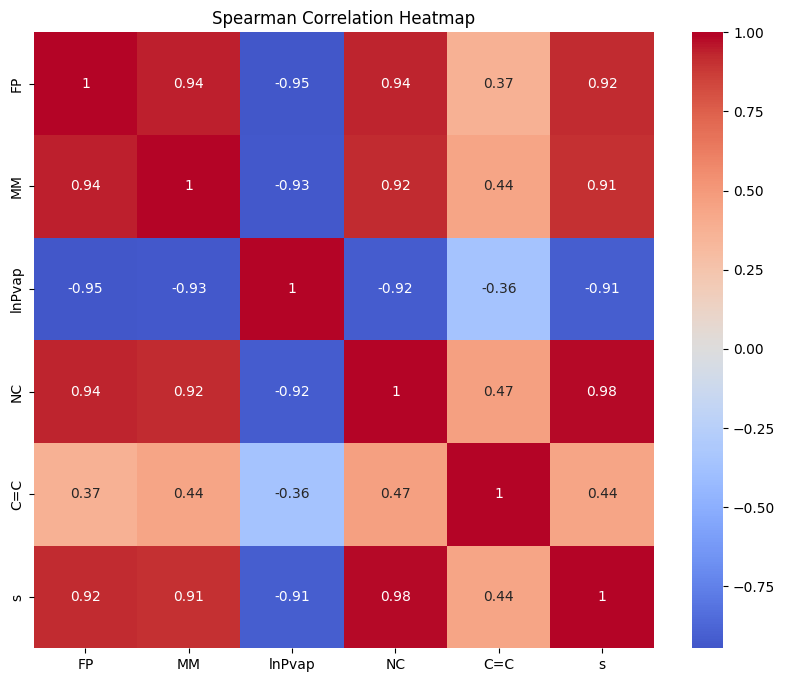

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fp_data = pd.read_csv("C:/Projetos/fp-neural-net/data/TCC_data.csv")

# Fill NaN values and remove duplicate ones, if exists
fp_data.fillna(0)
fp_data.drop_duplicates()

# Calculate Spearman correlation
selected_columns = [
    "FP",
    "MM",
    "lnPvap",
    "NC",
    "C=C",
    "s",
]  # The method column need to be desconsidered, since it related to the FP experimental method
filtered_data = fp_data[selected_columns]
spearman_corr = filtered_data.corr(method="spearman")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation Heatmap")
plt.show()

Based on the heatmap analysis, it was observed that the molar mass of the mixture (MM), the natural logarithm of the vapor pressure of the mixture (lnPvap), the number of carbons (NC), and the sum of the entropy of each component in the mixture (s) have a strong correlation with the flash point (FP). Consequently, the number of unsaturations in the carbon chain (C=C) was removed from consideration. Furthermore, due to the strong correlation between NC and s, NC was excluded from the modeling process. Entropy (s) provides detailed molecular information, which can more effectively describe the FP.

3/3 [==============================] - 0s 2ms/step - loss: 13.1621 - mae: 2.6073 - mse: 12.3690
MAE - 2.6072840690612793
RMSE - 3.516962636150977
3/3 [==============================] - 0s 1000us/step


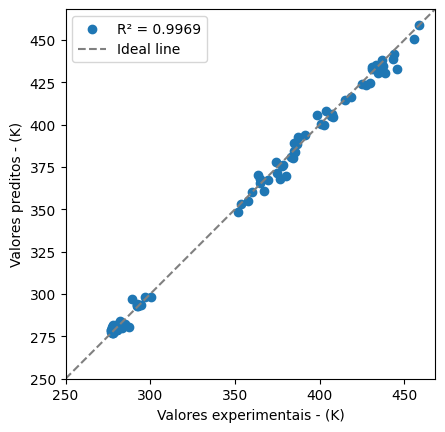

Model and scaler were succesfully saved
3/3 [==============================] - 0s 2ms/step - loss: 18.0787 - mae: 2.9845 - mse: 17.4182
MAE - 2.9845218658447266
RMSE - 4.173510741544826
3/3 [==============================] - 0s 1ms/step


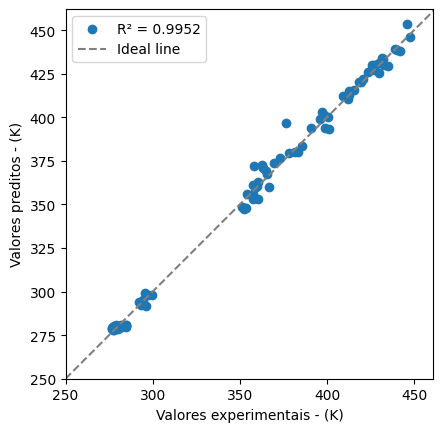

Model and scaler were succesfully saved
3/3 [==============================] - 0s 2ms/step - loss: 16.3308 - mae: 3.2603 - mse: 15.6127
MAE - 3.2602853775024414
RMSE - 3.9512854355668554
3/3 [==============================] - 0s 799us/step


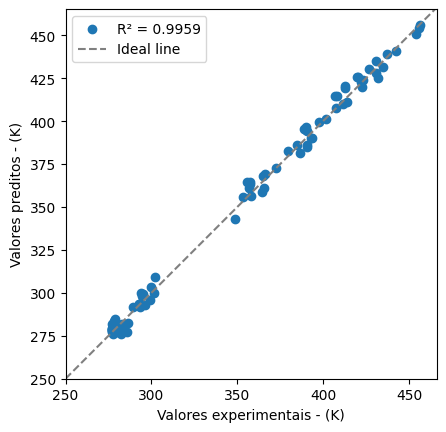

Model and scaler were succesfully saved
3/3 [==============================] - 0s 2ms/step - loss: 20.3317 - mae: 3.0051 - mse: 19.5958
MAE - 3.0051164627075195
RMSE - 4.426711386221086
3/3 [==============================] - 0s 1ms/step


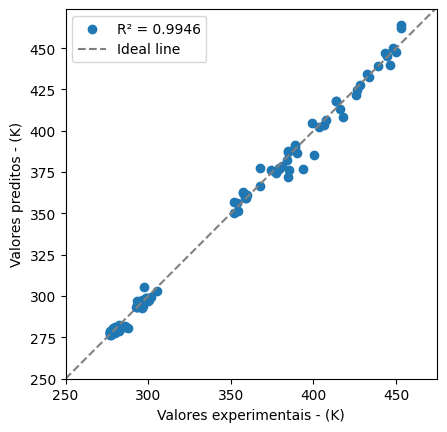

Model and scaler were succesfully saved
3/3 [==============================] - 0s 2ms/step - loss: 13.1965 - mae: 2.7334 - mse: 12.3446
MAE - 2.7333791255950928
RMSE - 3.5134835057553415
3/3 [==============================] - 0s 2ms/step


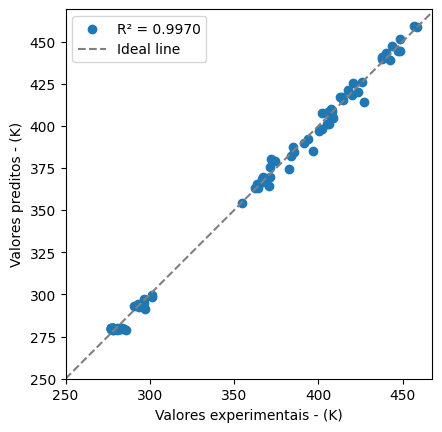

Model and scaler were succesfully saved
Average MAE = 2.918117380142212
Average RMSE = 3.9163907410478176


In [2]:
import numpy as np
import os
import sys
import uuid

from sklearn.model_selection import KFold

sys.path.append(os.path.abspath(".."))

from src.model_training import NeuralNet

# Remove NC and C=C
fp_data = fp_data.drop(columns=["NC", "C=C"])

# Split features and label
features = fp_data.iloc[:, 1:].values
label = fp_data.iloc[:, 0].values

# Train model using a cross-validation loop
mae_list = []
rmse_list = []
models_rmse = {}

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, test_idx in kf.split(features):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = label[train_idx], label[test_idx]

    model_id = uuid.uuid4()

    nn_exec = NeuralNet(X_train, X_test, y_train, y_test, model_id)
    mae, mse = nn_exec.execute_training_steps()

    mae_list.append(mae)
    rmse_list.append(np.sqrt(mse))
    models_rmse[model_id] = np.sqrt(mse)

print(f"Average MAE = {np.mean(mae_list)}")
print(f"Average RMSE = {np.mean(rmse_list)}")

In [5]:
import pickle as pkl

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model

# Get best model
best_model_id = min(models_rmse, key=models_rmse.get)

# Get Butanol + FAEE data and store the features and label values
but_data = pd.read_csv("C:/Projetos/fp-neural-net/data/butanol_data.csv")
but_features = but_data.iloc[:, 1:].values
but_label = fp_data.iloc[:, 0].values

# Load the scaler and the model
model = load_model(f"C:/Projetos/fp-neural-net/models/{best_model_id}.keras")

with open(f"C:/Projetos/fp-neural-net/models/scaler_{best_model_id}.pkl", "rb") as f:
    scaler = pkl.load(f)

# Predict values
scaled_features = scaler.transform(features)
y_pred = model.predict(scaled_features)

# Evaluate model metrics
but_rmse = np.sqrt(mean_squared_error(label, y_pred))
but_mae = mean_absolute_error(label, y_pred)

print(f"Butanol + FAEE RMSE = {round(but_rmse, 3)}")
print(f"Butanol + FAEE MAE = {round(but_mae, 3)}")

15/15 [==============================] - 0s 609us/step
Butanol + FAEE RMSE = 3.403
Butanol + FAEE MAE = 2.623
